# Import

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import time
# import re
import random
import pickle
import datasets as dst

import sklearn as skl
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, auc, roc_curve, confusion_matrix


import joblib

# Chargement des données et prétraitement

In [3]:
def preProcessDataframe(df: object) -> object:
    dfret = df.dropna(subset = [
        "station_id", 
        "lat", 
        "lon", 
        "occupation_prct", 
        "occupation_class"
    ]).copy()
    
    dfret['jour'] = dfret["time"].dt.day
    dfret['heure'] = dfret["time"].dt.hour
    dfret['minute'] = dfret["time"].dt.minute
    
    return dfret

In [4]:
path='F:/work/datasets/'
df0 = dst.getDataset("2023_03_17", path)
df1 = dst.getDataset("2023_03_18", path)
df2 = dst.getDataset("2023_03_19", path)
df3 = dst.getDataset("2023_03_20", path)
df4 = dst.getDataset("2023_03_21", path)
df5 = dst.getDataset("2023_03_22", path)

#Je réduis systématiquement la résolution en temps par 10 sur ce classeur
step=10
df0=df0.iloc[0::step]
df1=df1.iloc[0::step]
df2=df2.iloc[0::step]
df3=df3.iloc[0::step]
df4=df4.iloc[0::step]
df5=df5.iloc[0::step]


df0=preProcessDataframe(df0)
df1=preProcessDataframe(df1)
df2=preProcessDataframe(df2)
df3=preProcessDataframe(df3)
df4=preProcessDataframe(df4)
df5=preProcessDataframe(df5)

## Entrainement et prédiction

### Une station à la fois

In [5]:
df_tot=pd.concat([df0,df1])
df_tot=pd.concat([df_tot,df2])
df_tot=pd.concat([df_tot,df3])
df_tot=pd.concat([df_tot,df4])
df_tot=pd.concat([df_tot,df5])




In [7]:
station_list=list(set(df_tot.station_id))
station=random.sample(station_list,1)[0]
station

11437761399

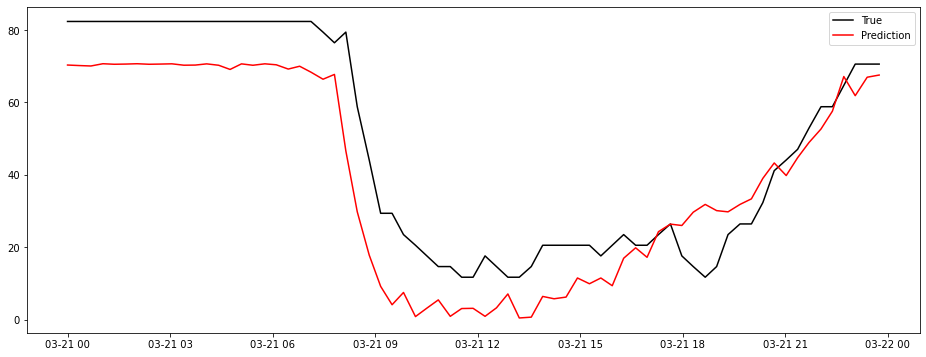

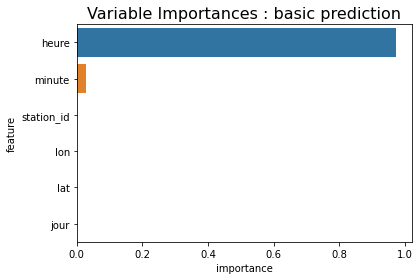

In [9]:
df_train=df_tot[df_tot["jour"] == 22]
df_train=df_train[df_train['station_id'] == station]

df_test=df_tot[df_tot["jour"] == 21]    
df_test=df_test[df_test['station_id'] == station]

feat = ["station_id", "lon", "lat", "jour", "heure", "minute"]
target = ["occupation_prct"]

x_train=df_train[feat]
y_train=df_train[target]

x_test=df_test[feat]
y_test=df_test[target]

clf = GradientBoostingRegressor(random_state=0)
clf.fit(x_train, y_train.values.ravel())

y_pred = clf.predict(x_test)

x=df_test['time']

plt.figure(figsize=(16,6))
plt.plot(x, y_test.values.ravel(), color='black', label='True')
plt.plot(x, y_pred, color='red', label='Prediction')


# plt.plot(x, y_train.values.ravel(), color='green', label='Veille')

plt.legend()
plt.show()


#create a dataframe with the variable importances of the model
df_importances = pd.DataFrame({
    'feature': clf.feature_names_in_,
    'importance': clf.feature_importances_
}).sort_values(by='importance', ascending=False)

#     print('feature', clf1.feature_names_in_,)
#     print(clf1.coef_)

#plot variable importances of the model
plt.title('Variable Importances : basic prediction', fontsize=16)
sns.barplot(x = df_importances.importance, y = df_importances.feature, orient='h')
plt.show()



In [12]:
str(station)

'11437761399'

In [14]:
#save weights 
model_filename = "velib_model_"+str(station)+".joblib.z"
joblib.dump((clf), model_filename)

['velib_model_11437761399.joblib.z']

In [15]:
x_test

,station_id,lon,lat,jour,heure,minute
1015980,11437761399,2.273421,48.913017,21,0,0
1015990,11437761399,2.273421,48.913017,21,0,21
1016000,11437761399,2.273421,48.913017,21,0,41
1016010,11437761399,2.273421,48.913017,21,1,2
1016020,11437761399,2.273421,48.913017,21,1,22
...,...,...,...,...,...,...
1016640,11437761399,2.273421,48.913017,21,22,22
1016650,11437761399,2.273421,48.913017,21,22,42
1016660,11437761399,2.273421,48.913017,21,23,2
1016670,11437761399,2.273421,48.913017,21,23,23


In [17]:
x_test.dtypes

station_id      int64
lon           float64
lat           float64
jour            int64
heure           int64
minute          int64
dtype: object

In [24]:
x_test_api=pd.DataFrame([[11437761399,2.273421,48.913017,21, 12, 0]], 
                        columns=['station_id','lon','lat','jour','heure','minute'])

In [25]:
y_pred_api = clf.predict(x_test_api)
y_pred_api

array([12.13966073])

In [2]:
station_info=pd.read_json('F:/work/download/stations_info.json').data[0]

In [57]:
station_info

[{'station_id': 213688169,
  'name': 'Benjamin Godard - Victor Hugo',
  'lat': 48.865983,
  'lon': 2.275725,
  'capacity': 35,
  'stationCode': '16107'},
 {'station_id': 653222953,
  'name': 'Mairie de Rosny-sous-Bois',
  'lat': 48.871256519012,
  'lon': 2.4865807592869,
  'capacity': 30,
  'stationCode': '31104',
  'rental_methods': ['CREDITCARD']},
 {'station_id': 36255,
  'name': 'Toudouze - Clauzel',
  'lat': 48.87929591733507,
  'lon': 2.3373600840568542,
  'capacity': 21,
  'stationCode': '9020',
  'rental_methods': ['CREDITCARD']},
 {'station_id': 37815204,
  'name': 'Mairie du 12ème',
  'lat': 48.840855311763,
  'lon': 2.3875549435616,
  'capacity': 30,
  'stationCode': '12109'},
 {'station_id': 17278902806,
  'name': "Rouget de L'isle - Watteau",
  'lat': 48.778192750803,
  'lon': 2.3963020229163,
  'capacity': 0,
  'stationCode': '44015'},
 {'station_id': 251039991,
  'name': 'Cassini - Denfert-Rochereau',
  'lat': 48.837525839067,
  'lon': 2.3360354080796,
  'capacity': 25,


In [83]:
for d in station_info:
    if d['station_id'] == 315022587 : 
        name,lat,lon =d['name'], d['lon'], d['lat']
#         break
name,lat,lon

('Malesherbes - Place de la Madeleine', 2.323243509807989, 48.87040602848252)

## toutes les stations

In [78]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import time
# import re
import random
import pickle
import datasets as dst

import sklearn as skl
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, auc, roc_curve, confusion_matrix

import joblib

###########################################################

def preProcessDataframe(df: object) -> object:
    dfret = df.dropna(subset = [
        "station_id", 
        "lat", 
        "lon", 
        "occupation_prct", 
        "occupation_class"
    ]).copy()
    
    dfret['jour'] = dfret["time"].dt.day
    dfret['heure'] = dfret["time"].dt.hour
    dfret['minute'] = dfret["time"].dt.minute
    
    return dfret


path='F:/work/datasets/'
df0 = dst.getDataset("2023_03_17", path)
df1 = dst.getDataset("2023_03_18", path)
df2 = dst.getDataset("2023_03_19", path)
df3 = dst.getDataset("2023_03_20", path)
df4 = dst.getDataset("2023_03_21", path)
df5 = dst.getDataset("2023_03_22", path)

#Je réduis systématiquement la résolution en temps par 10 sur ce classeur
step=10
df0=df0.iloc[0::step]
df1=df1.iloc[0::step]
df2=df2.iloc[0::step]
df3=df3.iloc[0::step]
df4=df4.iloc[0::step]
df5=df5.iloc[0::step]


df0=preProcessDataframe(df0)
df1=preProcessDataframe(df1)
df2=preProcessDataframe(df2)
df3=preProcessDataframe(df3)
df4=preProcessDataframe(df4)
df5=preProcessDataframe(df5)

df_tot=pd.concat([df0,df1])
df_tot=pd.concat([df_tot,df2])
df_tot=pd.concat([df_tot,df3])
df_tot=pd.concat([df_tot,df4])
df_tot=pd.concat([df_tot,df5])







###########################################################

station_list=list(set(df_tot.station_id))
dict_model={}


for station in station_list :

    df_train=df_tot[df_tot["jour"] == 22]
    df_train=df_train[df_train['station_id'] == station]

    df_test=df_tot[df_tot["jour"] == 21]    
    df_test=df_test[df_test['station_id'] == station]

    feat = ["station_id", "lon", "lat", "jour", "heure", "minute"]
    target = ["occupation_prct"]

    x_train=df_train[feat]
    y_train=df_train[target]

    x_test=df_test[feat]
    y_test=df_test[target]

    clf = GradientBoostingRegressor(random_state=0)
    clf.fit(x_train, y_train.values.ravel())

    dict_model[station]=clf
    
    
#save weights 
model_filename = "velib_model_all.joblib.z"
joblib.dump((dict_model), model_filename)



In [80]:
station_list

[1062223873,
 85008390,
 653197324,
 216039437,
 653123610,
 100859941,
 210583589,
 2515976231,
 488980540,
 85155919,
 1062797394,
 39149651,
 102309973,
 129081441,
 559980654,
 1057210479,
 213680246,
 15401095,
 126050442,
 82550925,
 213688462,
 76488849,
 653205656,
 80101533,
 214122655,
 214114469,
 80216231,
 268976295,
 85147829,
 42950839,
 653066427,
 224256188,
 653156540,
 125370566,
 1062256852,
 129089749,
 210387163,
 263610599,
 101753100,
 101761298,
 653107480,
 109609241,
 9931940126,
 331153695,
 210395439,
 35471668,
 649888071,
 49094984,
 357491025,
 419381597,
 39256416,
 102752610,
 632086890,
 1805255023,
 478593396,
 82583924,
 210567545,
 653140345,
 15409531,
 15163771,
 49791363,
 34300292,
 74858883,
 653091206,
 244498842,
 213680553,
 532054446,
 653099465,
 121086415,
 42541542,
 101024234,
 214139374,
 100868590,
 213688824,
 102326776,
 1056965116,
 80298493,
 245187072,
 452936197,
 271540743,
 30179848,
 653050378,
 125542925,
 129106450,
 20595

# distance entre stations : 

In [48]:
#Calcul de distance 
# from math import radians, sin, cos, sqrt, atan2
from math import radians, sin, cos, sqrt, asin

def distance(lon1, lat1, lon2, lat2):
    # approximate radius of earth in km
    R = 6373.0

    # convert latitudes and longitudes from degrees to radians
    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    # apply the Haversine formula to calculate the distance
    h = sin((lat2-lat1) / 2)**2 + cos(lat1) * cos(lat2) * sin((lon2-lon1) / 2)**2
    distance = 2*R*asin(sqrt( h ))
    
    return distance

   
   #Sélectionne les nmax stations les plus proches de la position (lat,lon)
def get_station_close(lat, lon, nmax=5 ):
    n=0
    dict_distance={}
    for station in station_info:
        dict_distance[station['station_id']]=distance(station['lon'], station['lat'], lon_u, lat_u)

    key_list=sorted(dict_distance)[:nmax]

    selected_station=[]
    for station in station_info:
        if station['station_id'] in key_list:
            station['distance']=dict_distance[station['station_id']]
            selected_station.append(station)
        
    
    return selected_station

In [70]:
lat_u=random.uniform(48.8,48.9)
lon_u=random.uniform(2.3,2.4)
stat_near=get_station_close(lat_u, lon_u)

print(lat_u, lon_u)
stat_near

48.83077974695263 2.3518928332183497


[{'station_id': 6296,
  'name': 'Institut de France',
  'lat': 48.857615678565,
  'lon': 2.3358313530377,
  'capacity': 17,
  'stationCode': '6001',
  'rental_methods': ['CREDITCARD'],
  'distance': 3.20815916416847},
 {'station_id': 6295,
  'name': 'Pontoise - La Tournelle',
  'lat': 48.850458009188,
  'lon': 2.3524542754922,
  'capacity': 23,
  'stationCode': '5107',
  'rental_methods': ['CREDITCARD'],
  'distance': 2.189195690457377},
 {'station_id': 6294,
  'name': 'Marché aux fleurs',
  'lat': 48.85525811539143,
  'lon': 2.347375452518463,
  'capacity': 23,
  'stationCode': '4002',
  'rental_methods': ['CREDITCARD'],
  'distance': 2.7427329136123153},
 {'station_id': 6293,
  'name': 'Mairie du 2ème',
  'lat': 48.8672190355135,
  'lon': 2.340462543774704,
  'capacity': 28,
  'stationCode': '2008',
  'distance': 4.138582458494577},
 {'station_id': 6245,
  'name': 'Ventadour - Opéra',
  'lat': 48.866810653323,
  'lon': 2.334388448251871,
  'capacity': 27,
  'stationCode': '1116',
  '

In [76]:
from colour import Color
red=Color("red")
colors = list(red.range_to(Color("green").hex,10))
print(colors)

[<Color red>, <Color #f13600>, <Color #e36500>, <Color #d58e00>, <Color #c7b000>, <Color #a4b800>, <Color #72aa00>, <Color #459c00>, <Color #208e00>, <Color green>]


In [94]:
#Variables :
station_info=pd.read_json('../stations_info.json').data[0]


model_dict = joblib.load("velib_model_all.joblib.z")

In [95]:
from flask import Flask, jsonify, request, render_template


import joblib
from flask_bootstrap import Bootstrap

import pandas
import pandas as pd
import sklearn
import random
import re
import numpy as np
from math import radians, sin, cos, sqrt, asin


import folium
import sys
from colour import Color





#Fonctions et variables nécessaires à la prédiction : 

def predict_occup(model, x_test):

    # On prédit sur les données de test
    y_pred = model.predict(x_test)
    y_pred=f"{y_pred[0]:3.1f}"
  
    return y_pred


def format_predict_input(station_id: int, lat: float, lon: float, time_str: str):
    #Combines the results from various sources to format the features used for
    # the prediction in a way compatible with the prediction model.
    
    
    # 'time_str' is returned by the html page in the format "2023-03-23T12:00")
    # annee=int(time_str[:4]) #Unused for now
    # mois=int(time_str[5:7]) #Unused for now
    jour=int(time_str[8:10])
    heure=int(time_str[11:13])
    minute=int(time_str[14:16])

    # x_test=pd.DataFrame([[11437761399,2.273421,48.913017,jour, heure, minute]], 
    x_test=pd.DataFrame([[station_id,lon,lat,jour, heure, minute]], 
                        columns=['station_id','lon','lat','jour','heure','minute'])
    
    return x_test


def get_station_info(station_info: object, station_id: str):
    
    # name="Henri Barbusse - Bourguignons"
    
    name, lat, lon = 'station_not_found', 0, 0
    for d in station_info:
        if d['station_id'] == station_id : 
            name, lat, lon, cap = d['name'], float(d['lon']), float(d['lat']), int(d['capacity'])
            
            # break
        
    return name, lat, lon, cap


# lat=48.856614, lon=2.3522219
def get_iframe(lat=48.856614, lon=2.3522219, zoom=12, time_str=""):
    """Create a map as an iframe to embed on a page."""
    m = folium.Map(location=[lat, lon], 
        zoom_start=zoom )

    # set the iframe width and height
    m.get_root().width = "800px"
    m.get_root().height = "600px"

    # for k,v in station_info.iterrows():
    for v in station_info:
        # if not v['station_id'] in [1062223873, 85008390, 653197324, 216039437, 653123610] :
            # continue


        # y_test=float(get_table_line(v, time_str , ret_classif=1))
        
        folium.CircleMarker(
            # location = [v.lat, v.lon],
            location = [v['lat'], v['lon']],
            color = "#000000",
            weight = 2,
            # fill_color = red(abs(v.y_test/100)).hex,            
            # fill_color = red(abs(y_test)).hex,            
            fill_color = "#000000",
            fill_opacity = 1.0,
            # popup = str(v.y_test) + " % ",
            popup = "Station "+str(v['station_id']),
            radius = 5
        ).add_to(m)


    #Marker for the user's position
    folium.CircleMarker(
        # location = [v.lat, v.lon],
        location = [lat, lon],
        color = "#000000",
        weight = 2,
        # fill_color = red(abs(v.y_test/100)).hex,
        fill_color = "#000000",
        fill_opacity = 1.0,
        # popup = str(v.y_test) + " % ",
        popup = "User",
        radius = 5
    ).add_to(m)

    iframe = m.get_root()._repr_html_()

    return iframe




# Pour faire un dégradé de couleurs
# Dans cet exemple: 10 étapes pour passer du rouge au vert
red = Color("red")
colors = list(red.range_to(Color("green").hex,10))

def red(brightness):
    #print(brightness)
    brightness = min([int(round(9 * brightness)),9]) # convert from 0.0-1.0 to 0-255
    return colors[brightness]



#Compute the distance in km between two points knowing their latitudes and
# longitudes (cf wikipedia haversine formula)
def distance(lon1 :float, lat1 :float, lon2 :float, lat2 :float):
    # approximate radius of earth in km
    R = 6373.0

    # convert latitudes and longitudes from degrees to radians
    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    # apply the Haversine formula to calculate the distance
    h = sin((lat2-lat1) / 2)**2 + cos(lat1) * cos(lat2) * sin((lon2-lon1) / 2)**2
    distance = 2*R*asin(sqrt( h ))
    
    return distance



#Selects the nmax stations closest to the position (lat,lon)
def get_station_close(lat :float, lon :float, nmax=5 ):
    dict_distance={}
    for station in station_info:
        dict_distance[station['station_id']]=distance(station['lon'], station['lat'], lon, lat)

    key_list=sorted(dict_distance)[:nmax]

    selected_station=[]
    for station in station_info:
        if station['station_id'] in key_list:
            station['distance']=dict_distance[station['station_id']]
            selected_station.append(station)
        
    
    return selected_station




def get_table_line(station, time_str , ret_classif=0):
     
   
    station_int=station['station_id']
    lon=station['lon']
    lat=station['lat']
    jour=int(time_str[8:10])
    heure=int(time_str[11:13])
    minute=int(time_str[14:16])

 
    x_test=pd.DataFrame([[station_int,lon,lat,jour, heure, minute]], 
                 columns=['station_id','lon','lat','jour','heure','minute'])

 
    model = model_dict[station_int]

    #Predict the occupation percentage
    classif=predict_occup(model,x_test)
    if ret_classif :
        return classif


    name=station['name']
    station_code=station['stationCode']
    distance=station['distance']
    capacity=station['capacity']
    foo=len(station)

    print(classif, capacity)
    table_line=(name, station_code, distance, np.round(float(classif)*capacity/100.), foo)
    return table_line

In [106]:
# On récupère le champ namequery du template index
# format : text="2023-03-23T12:00"
time_str = "2023-03-23T12:00"


#On n'utilisera pas une station_id en entrée mais une position de
# l'utilisateur à base de latitude/longitude
lat_u=random.uniform(48.8,48.9) 
lon_u=random.uniform(2.3,2.4)

# print(lat_u, lon_u)
selected_station=get_station_close(lat_u, lon_u)
#
print(lat_u, lon_u)
print(selected_station)



48.79440099469129 2.2689530895285204
[{'station_id': 6296, 'name': 'Institut de France', 'lat': 48.857615678565, 'lon': 2.3358313530377, 'capacity': 17, 'stationCode': '6001', 'rental_methods': ['CREDITCARD'], 'distance': 8.56878580695325}, {'station_id': 6295, 'name': 'Pontoise - La Tournelle', 'lat': 48.850458009188, 'lon': 2.3524542754922, 'capacity': 23, 'stationCode': '5107', 'rental_methods': ['CREDITCARD'], 'distance': 8.733370018015444}, {'station_id': 6294, 'name': 'Marché aux fleurs', 'lat': 48.85525811539143, 'lon': 2.347375452518463, 'capacity': 23, 'stationCode': '4002', 'rental_methods': ['CREDITCARD'], 'distance': 8.877009534786175}, {'station_id': 6293, 'name': 'Mairie du 2ème', 'lat': 48.8672190355135, 'lon': 2.340462543774704, 'capacity': 28, 'stationCode': '2008', 'distance': 9.644587258171569}, {'station_id': 6245, 'name': 'Ventadour - Opéra', 'lat': 48.866810653323, 'lon': 2.3343884482519, 'capacity': 27, 'stationCode': '1116', 'rental_methods': ['CREDITCARD'], 'di

In [109]:
lat_u=random.uniform(48.8,48.9) 
lon_u=random.uniform(2.3,2.4)
get_station_close(lat_u, lon_u)

[{'station_id': 6296,
  'name': 'Institut de France',
  'lat': 48.857615678565,
  'lon': 2.3358313530377,
  'capacity': 17,
  'stationCode': '6001',
  'rental_methods': ['CREDITCARD'],
  'distance': 3.083847441416197},
 {'station_id': 6295,
  'name': 'Pontoise - La Tournelle',
  'lat': 48.850458009188,
  'lon': 2.3524542754922,
  'capacity': 23,
  'stationCode': '5107',
  'rental_methods': ['CREDITCARD'],
  'distance': 1.9345394889363827},
 {'station_id': 6294,
  'name': 'Marché aux fleurs',
  'lat': 48.85525811539143,
  'lon': 2.347375452518463,
  'capacity': 23,
  'stationCode': '4002',
  'rental_methods': ['CREDITCARD'],
  'distance': 2.529312318796944},
 {'station_id': 6293,
  'name': 'Mairie du 2ème',
  'lat': 48.8672190355135,
  'lon': 2.340462543774704,
  'capacity': 28,
  'stationCode': '2008',
  'distance': 3.9464565954615503},
 {'station_id': 6245,
  'name': 'Ventadour - Opéra',
  'lat': 48.866810653323,
  'lon': 2.3343884482519,
  'capacity': 27,
  'stationCode': '1116',
  '

In [96]:
#We generate the list "my_list" that is used to create the tables in
# the html by looping on each selected station
my_list=[]
for station in selected_station :
    my_list.append(get_table_line(station, time_str))



# iframe=get_iframe()
# iframe=get_iframe(lat_u, lon_u, 16, time_str)

# Render the response in the result.html template
# return render_template('predict.html', my_list=my_list, hour1=time_str[11:16], iframe=iframe)

87.2 17
31.4 23
81.7 23
74.3 28
0.7 27


In [99]:
my_list

[('Institut de France', '6001', 3.358076654416794, 15.0, 8),
 ('Pontoise - La Tournelle', '5107', 4.4620527020497205, 7.0, 8),
 ('Marché aux fleurs', '4002', 3.828446405928245, 19.0, 8),
 ('Mairie du 2ème', '2008', 2.405115621168953, 21.0, 7),
 ('Ventadour - Opéra', '1116', 2.331649154675651, 0.0, 8)]

In [100]:
selected_station

[{'station_id': 6296,
  'name': 'Institut de France',
  'lat': 48.857615678565,
  'lon': 2.3358313530377,
  'capacity': 17,
  'stationCode': '6001',
  'rental_methods': ['CREDITCARD'],
  'distance': 3.358076654416794},
 {'station_id': 6295,
  'name': 'Pontoise - La Tournelle',
  'lat': 48.850458009188,
  'lon': 2.3524542754922,
  'capacity': 23,
  'stationCode': '5107',
  'rental_methods': ['CREDITCARD'],
  'distance': 4.4620527020497205},
 {'station_id': 6294,
  'name': 'Marché aux fleurs',
  'lat': 48.85525811539143,
  'lon': 2.347375452518463,
  'capacity': 23,
  'stationCode': '4002',
  'rental_methods': ['CREDITCARD'],
  'distance': 3.828446405928245},
 {'station_id': 6293,
  'name': 'Mairie du 2ème',
  'lat': 48.8672190355135,
  'lon': 2.340462543774704,
  'capacity': 28,
  'stationCode': '2008',
  'distance': 2.405115621168953},
 {'station_id': 6245,
  'name': 'Ventadour - Opéra',
  'lat': 48.866810653323,
  'lon': 2.3343884482519,
  'capacity': 27,
  'stationCode': '1116',
  'r

In [83]:
for station in selected_station :
    print(station)
    print(get_table_line(station, time_str))

{'station_id': 6296, 'name': 'Institut de France', 'lat': 48.857615678565, 'lon': 2.3358313530377, 'capacity': 17, 'stationCode': '6001', 'rental_methods': ['CREDITCARD'], 'distance': 0.8495774546569903}
('Institut de France', '6001', 0.8495774546569903, '87.287.287.287.287.287.287.287.2', 8)
{'station_id': 6295, 'name': 'Pontoise - La Tournelle', 'lat': 48.850458009188, 'lon': 2.3524542754922, 'capacity': 23, 'stationCode': '5107', 'rental_methods': ['CREDITCARD'], 'distance': 1.3038377781130237}
('Pontoise - La Tournelle', '5107', 1.3038377781130237, '31.431.431.431.431.431.431.431.4', 8)
{'station_id': 6294, 'name': 'Marché aux fleurs', 'lat': 48.85525811539143, 'lon': 2.347375452518463, 'capacity': 23, 'stationCode': '4002', 'rental_methods': ['CREDITCARD'], 'distance': 0.6877519786610835}
('Marché aux fleurs', '4002', 0.6877519786610835, '81.781.781.781.781.781.781.781.7', 8)
{'station_id': 6293, 'name': 'Mairie du 2ème', 'lat': 48.8672190355135, 'lon': 2.340462543774704, 'capacit

In [86]:
print(station.occupacy)

AttributeError: 'dict' object has no attribute 'occupacy'

In [121]:
lat=lat_u
lon=lon_u
nmax=5
dict_distance={}
for station in station_info:
    dict_distance[station['station_id']]=distance(station['lon'], station['lat'], lon, lat)

    
key_list=sorted(dict_distance)[:nmax]
print(key_list)

# key_list=sorted(dict_distance.items(), key=lambda item: item[1])
key_list=[]
for k, v in sorted(dict_distance.items(), key=lambda item: item[1])[:nmax] :
    key_list.append(k)
print(key_list)


[6245, 6293, 6294, 6295, 6296]
[27415083, 284787594, 66491398, 210751059, 27415150]


In [122]:
colors


[<Color red>,
 <Color #f13600>,
 <Color #e36500>,
 <Color #d58e00>,
 <Color #c7b000>,
 <Color #a4b800>,
 <Color #72aa00>,
 <Color #459c00>,
 <Color #208e00>,
 <Color green>]